In [1]:
! pip install -U git+https://github.com/optuna/optuna.git -q # install last version of optuna

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import json
import gc
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Any results you write to the current directory are saved as output.

### Читаем данные

In [3]:
from pathlib import Path

In [4]:
preprocessed_path = Path('/') / 'kaggle' / 'input' / 'citymobil-preprocessed'
train = pd.read_csv(preprocessed_path / 'train_preprocessed.csv', index_col='Id')
valid = pd.read_csv(preprocessed_path / 'valid_preprocessed.csv', index_col='Id')
test = pd.read_csv(preprocessed_path / 'test_preprocessed.csv', index_col='Id')

In [5]:
geofeatures_path = Path('/') / 'kaggle' / 'input' / 'geofeatures'
train_geo = pd.read_csv(geofeatures_path / 'geofeatures_train.csv', index_col='Id')
valid_geo = pd.read_csv(geofeatures_path / 'geofeatures_val.csv', index_col='Id')
test_geo = pd.read_csv(geofeatures_path / 'geofeatures_test.csv', index_col='Id')

Объединяем фичи вместе

In [6]:
train = train.merge(train_geo, left_index=True, right_index=True, how='left')
valid = valid.merge(valid_geo, left_index=True, right_index=True, how='left')
test = test.merge(test_geo, left_index=True, right_index=True, how='left')

### Подготовка для обучения
К сожалению в тесте для совсем малой части маршрутов нет пути, поэтому для этих записей заполним пропущенные значениями средними по train

In [7]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
train[train_geo.columns] = imp_mean.fit_transform(train[train_geo.columns])
valid[train_geo.columns] = imp_mean.transform(valid[train_geo.columns])
test[train_geo.columns] = imp_mean.transform(test[train_geo.columns])

In [8]:
columns_for_training = test.columns.difference(['OrderedDate']) # уже итак извлекли фичи из времени

Одно из ключевых: **предсказываем не `RTA` напрямую, а насколько ошибается текущая модель**  
Так как это поможет лучше понять какие факторы влияют на ошибку модели

In [9]:
X_train, y_train = train[columns_for_training], train['ETA'] - train['RTA']
X_valid, y_valid = valid[columns_for_training], valid['ETA'] - valid['RTA']

Lightgbm поддерживает категориальные фичи: [source](https://lightgbm.readthedocs.io/en/latest/Features.html#optimal-split-for-categorical-features)

In [10]:
feature_names = list(X_train.columns)

In [11]:
import category_encoders as ce
categorical_columns = ['main_id_locality', 'day_of_week', 'pickup_hash', 'del_hash']
encoder = ce.OrdinalEncoder(cols=categorical_columns)

In [12]:
X_train = encoder.fit_transform(X_train)
X_valid = encoder.transform(X_valid)

### Задание hyperparameter optimization и обучение
Подбираем параметры при помощи LightGBM Tuner in [Optuna](https://github.com/optuna/optuna) ([ссылка на статью с примером](https://medium.com/optuna/lightgbm-tuner-new-optuna-integration-for-hyperparameter-optimization-8b7095e99258)). Активно развивается, поэтому есть смысл смотреть сразу [исходный код](https://github.com/optuna/optuna/tree/3fe0ab712096eaf434e521b1b0b4f0fab4dc8740/optuna/integration/lightgbm_tuner).

In [13]:
import optuna
import optuna.integration.lightgbm as lgb
optuna.__version__

'1.3.0'

In [14]:
d_train = lgb.Dataset(X_train, label=y_train, feature_name=feature_names, categorical_feature=categorical_columns, free_raw_data=False)
d_valid = lgb.Dataset(X_valid, label=y_valid, feature_name=feature_names, categorical_feature=categorical_columns, free_raw_data=False)
gc.collect()

0

In [15]:
boosting_static_params = {
        "objective": "regression",
        "metric": "l2",
        "verbosity": 0,
        "boosting_type": "gbdt",
}

In [16]:
study = optuna.create_study(direction="minimize")

In [17]:
from datetime import timedelta
time_to_train = timedelta(hours=6).seconds

In [18]:
model = lgb.train(
        params=boosting_static_params, 
        train_set=d_train, valid_sets=[d_valid], 
        early_stopping_rounds=300, num_boost_round=6000,
        verbose_eval=0, 
        study=study, time_budget=time_to_train,
        model_dir='/kaggle/working/boostings',
)

/opt/conda/lib/python3.7/site-packages/optuna/_experimental.py:90: ExperimentalWarning:

train is experimental (supported from v0.18.0). The interface can change in the future.

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.

[I 2020-04-29 01:45:14,585] The booster of trial#0 was saved as /kaggle/working/boostings/0.pkl.
bagging, val_score: 24264.155148: 100%|##########| 10/10 [16:02<00:00, 96.22s/it]
feature_fraction_stage2, val_score: 24264.155148:   0%|          | 0/6 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.

[I 2020-04-29 03:07:27,769] The booster of trial#37 was saved as /kaggle/working/boostings/37.pkl.
feature_fraction_stage2, val_score: 24264.155148:  17%|#6        | 1/6 [01:39<08:19, 99.84s/it][I 2020-04-29 03:07:27,910] Finished trial#37 with value: 2

Сохраним результаты обучения

In [19]:
from joblib import dump
dump(study, "study.joblib")

['study.joblib']

### Оцениваним качество модели

In [20]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

def mean_absolute_percentage_error(y_true, y_pred):
    mask = (y_true != 0)
    return (np.fabs(y_true - y_pred) / y_true)[mask].mean() * 100

def calculate_metrics(y_true, y_pred):
    print(f"MAPE: {mean_absolute_percentage_error(y_true, y_pred)}")
    print(f"mse: {mean_squared_error(y_true, y_pred)}")
    print(f"r2: {r2_score(y_true, y_pred)}")

Пару слов про оценивание:
* можно оценивать по метрикам предсказанную и настоящую разницу между `ETA` и `RTA`
* можно получить предсказанное `RTA` и сравнить с настоящим  
Также стоит сделать пояснения насчет того, как можно немного улучшить точность предсказания:
* можно посчитать насколько наша разница в среднем отличается от настоящей
* и дополнительно вычесть посчитанное на предыдущем пункте смещение
* а можно посчитать разницу не в целом, а для каждого города в отдельности

In [21]:
from joblib import dump

def calculate_valid_metrics(clf, prefix=''):
    clf_name = f"{prefix}_{clf.__class__.__name__}"
    print(f'Evaluating {clf_name}')
    clf.save_model(f'{clf_name}.txt')
    dump(clf, f"{clf_name}.joblib")
    
    y_valid_pred = clf.predict(X_valid)
    print(f"Prediction diff: {y_valid_pred.mean()},\tTrue diff: {(valid['ETA'] - valid['RTA']).mean()}", end='\t')
    prediction_diff_bias = (valid['ETA'] - valid['RTA']).mean() - y_valid_pred.mean()
    print(f'Bias of two differences: {prediction_diff_bias}')
    
    valid['pred_diff'] = y_valid_pred
    valid['pred'] = valid['ETA'] - y_valid_pred
    
    prediction_diff_by_group = valid.groupby(by='main_id_locality').apply(lambda x: (x['ETA'] - x['RTA']).mean() - x['pred_diff'].mean()).to_frame(name = 'diff').reset_index()
    print(prediction_diff_by_group)
    
    print("Diff metrics")
    calculate_metrics(y_valid, y_valid_pred)
    
    print("True RTA metrics")
    calculate_metrics(valid['RTA'], valid['pred'])
    
    print("True RTA metrics with bias substracting")
    calculate_metrics(valid['RTA'], valid['pred'] - prediction_diff_bias)
    
    print("True RTA metrics with bias substracting by group")
    calculate_metrics(valid['RTA'], valid['pred'] - valid.merge(prediction_diff_by_group)['diff'])
    
    return prediction_diff_bias, prediction_diff_by_group

In [22]:
prediction_diff_bias, prediction_diff_by_group = calculate_valid_metrics(model, prefix='hpo')

Evaluating hpo_Booster
Prediction diff: 173.43885268721547,	True diff: 199.24604850326577	Bias of two differences: 25.807195816050296
   main_id_locality       diff
0              1078  29.433199
1             22390  13.688322
2             22430  10.245775
3             22438  39.028249
Diff metrics
MAPE: 21.63461131189088
mse: 24195.60456473003
r2: 0.5582615994413989
True RTA metrics
MAPE: 15.157960024167854
mse: 24195.60456473003
r2: 0.8795024762075245
True RTA metrics with bias substracting
MAPE: 14.061333364563843
mse: 23529.593208842067
r2: 0.8828193067081831
True RTA metrics with bias substracting by group
MAPE: 14.082883780859262
mse: 23414.918527629543
r2: 0.8833904027967653


Опционально можно доучить модель на данных из валидации

In [23]:
refit_on_valid = False
if refit_on_valid:
    booster = model.refit(X_valid, y_valid)

### Получаем и сохраняем прогнозы для тестовых данных
Здесь тоже можно воспользоваться рассуждениями из прошлого пункта

In [24]:
def prepate_test_submsission(clf, prediction_diff_bias, prediction_diff_by_group, prefix):
    prefix = Path(prefix)
    prefix.mkdir(exist_ok=True)
    
    X_test = test[columns_for_training]
    X_test = encoder.transform(X_test)
    
    test_pred = clf.predict(X_test)
    print(f"Mean of diff on test is {test_pred.mean()}")
    
    submission = pd.DataFrame(index=test.index)
    
    submission['Prediction'] = test['ETA'] - test_pred
    submission.to_csv(prefix / "submission_pure.csv")
    
    submission['Prediction'] = test['ETA'] - test_pred - prediction_diff_bias
    submission.to_csv(prefix / "submission_without_bias.csv")
    
    correction = valid['pred_diff'].mean() - test_pred.mean()
    submission['Prediction'] += correction
    submission.to_csv(prefix / "submission_without_bias_corrected.csv")
    
    submission['main_id_locality'] = test['main_id_locality']
    submission['Prediction'] = submission['Prediction'] - test.merge(prediction_diff_by_group)['diff']
    submission.drop(columns='main_id_locality', inplace=True)
    submission.to_csv(prefix / "submission_without_bias_grouped.csv")
    
    submission['Prediction'] += correction
    submission.to_csv(prefix / "submission_without_bias_grouped_corrected.csv")

In [25]:
prepate_test_submsission(model, prediction_diff_bias, prediction_diff_by_group, prefix='hpo')

Mean of diff on test is 172.20121176808087


## Дообучение
Можно дообучить модель с лучшими параметрами на всем датасете целиком

In [26]:
print('Best parameters: ' + json.dumps(study.best_params, indent=4))

Best parameters: {
    "min_child_samples": 100
}


In [27]:
import lightgbm as original_lightgbm

In [28]:
model_retrained = original_lightgbm.train(
    params={**boosting_static_params, **study.best_params, 'learning_rate': 0.03}, # lower learning rate
    train_set=d_train, valid_sets=[d_valid],
    feature_name=feature_names, categorical_feature=categorical_columns,
    init_model=model,
    verbose_eval=400,
    early_stopping_rounds=600, num_boost_round=int(1e6))

Training until validation scores don't improve for 600 rounds
[800]	valid_0's l2: 24215.5
Early stopping, best iteration is:
[430]	valid_0's l2: 24195.9


In [29]:
prediction_diff_bias, prediction_diff_by_group = calculate_valid_metrics(model_retrained, prefix='hpo_retrained')

Evaluating hpo_retrained_Booster
Prediction diff: 173.4386395338328,	True diff: 199.24604850326577	Bias of two differences: 25.80740896943297
   main_id_locality       diff
0              1078  29.432157
1             22390  13.690514
2             22430  10.248623
3             22438  39.027326
Diff metrics
MAPE: 21.63375714510903
mse: 24195.85752334409
r2: 0.5582569811838438
True RTA metrics
MAPE: 15.15794550196926
mse: 24195.85752334409
r2: 0.8795012164379439
True RTA metrics with bias substracting
MAPE: 14.06131617555863
mse: 23529.835165628512
r2: 0.8828181017292558
True RTA metrics with bias substracting by group
MAPE: 14.08287705788723
mse: 23415.193620876074
r2: 0.8833890327935926


In [30]:
refit_on_valid = False
if refit_on_valid:
    model_retrained = model_retrained.refit(X_valid, y_valid)

Получаем предсказания дообученной модели

In [31]:
prepate_test_submsission(model_retrained, prediction_diff_bias, prediction_diff_by_group, prefix='hpo_retrained')

Mean of diff on test is 172.20080503459522


# Feature importance

In [32]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [33]:
def plot_importance(model, importance_type='split'):
    """
    importance_type could be split or 'gain'
    """
    feat_importance = pd.DataFrame()
    feat_importance["feature"] = X_train.columns
    feat_importance[importance_type] = model.feature_importance(importance_type=importance_type)
    feat_importance = feat_importance.sort_values(by=importance_type, ascending=False).head(20)
    fig = plt.figure(figsize=(20, 10)) 
    ax = sns.barplot(y="feature", x=importance_type, data=feat_importance) 
    plt.show() 
    fig.savefig(f"feature_importance_{importance_type}.png")

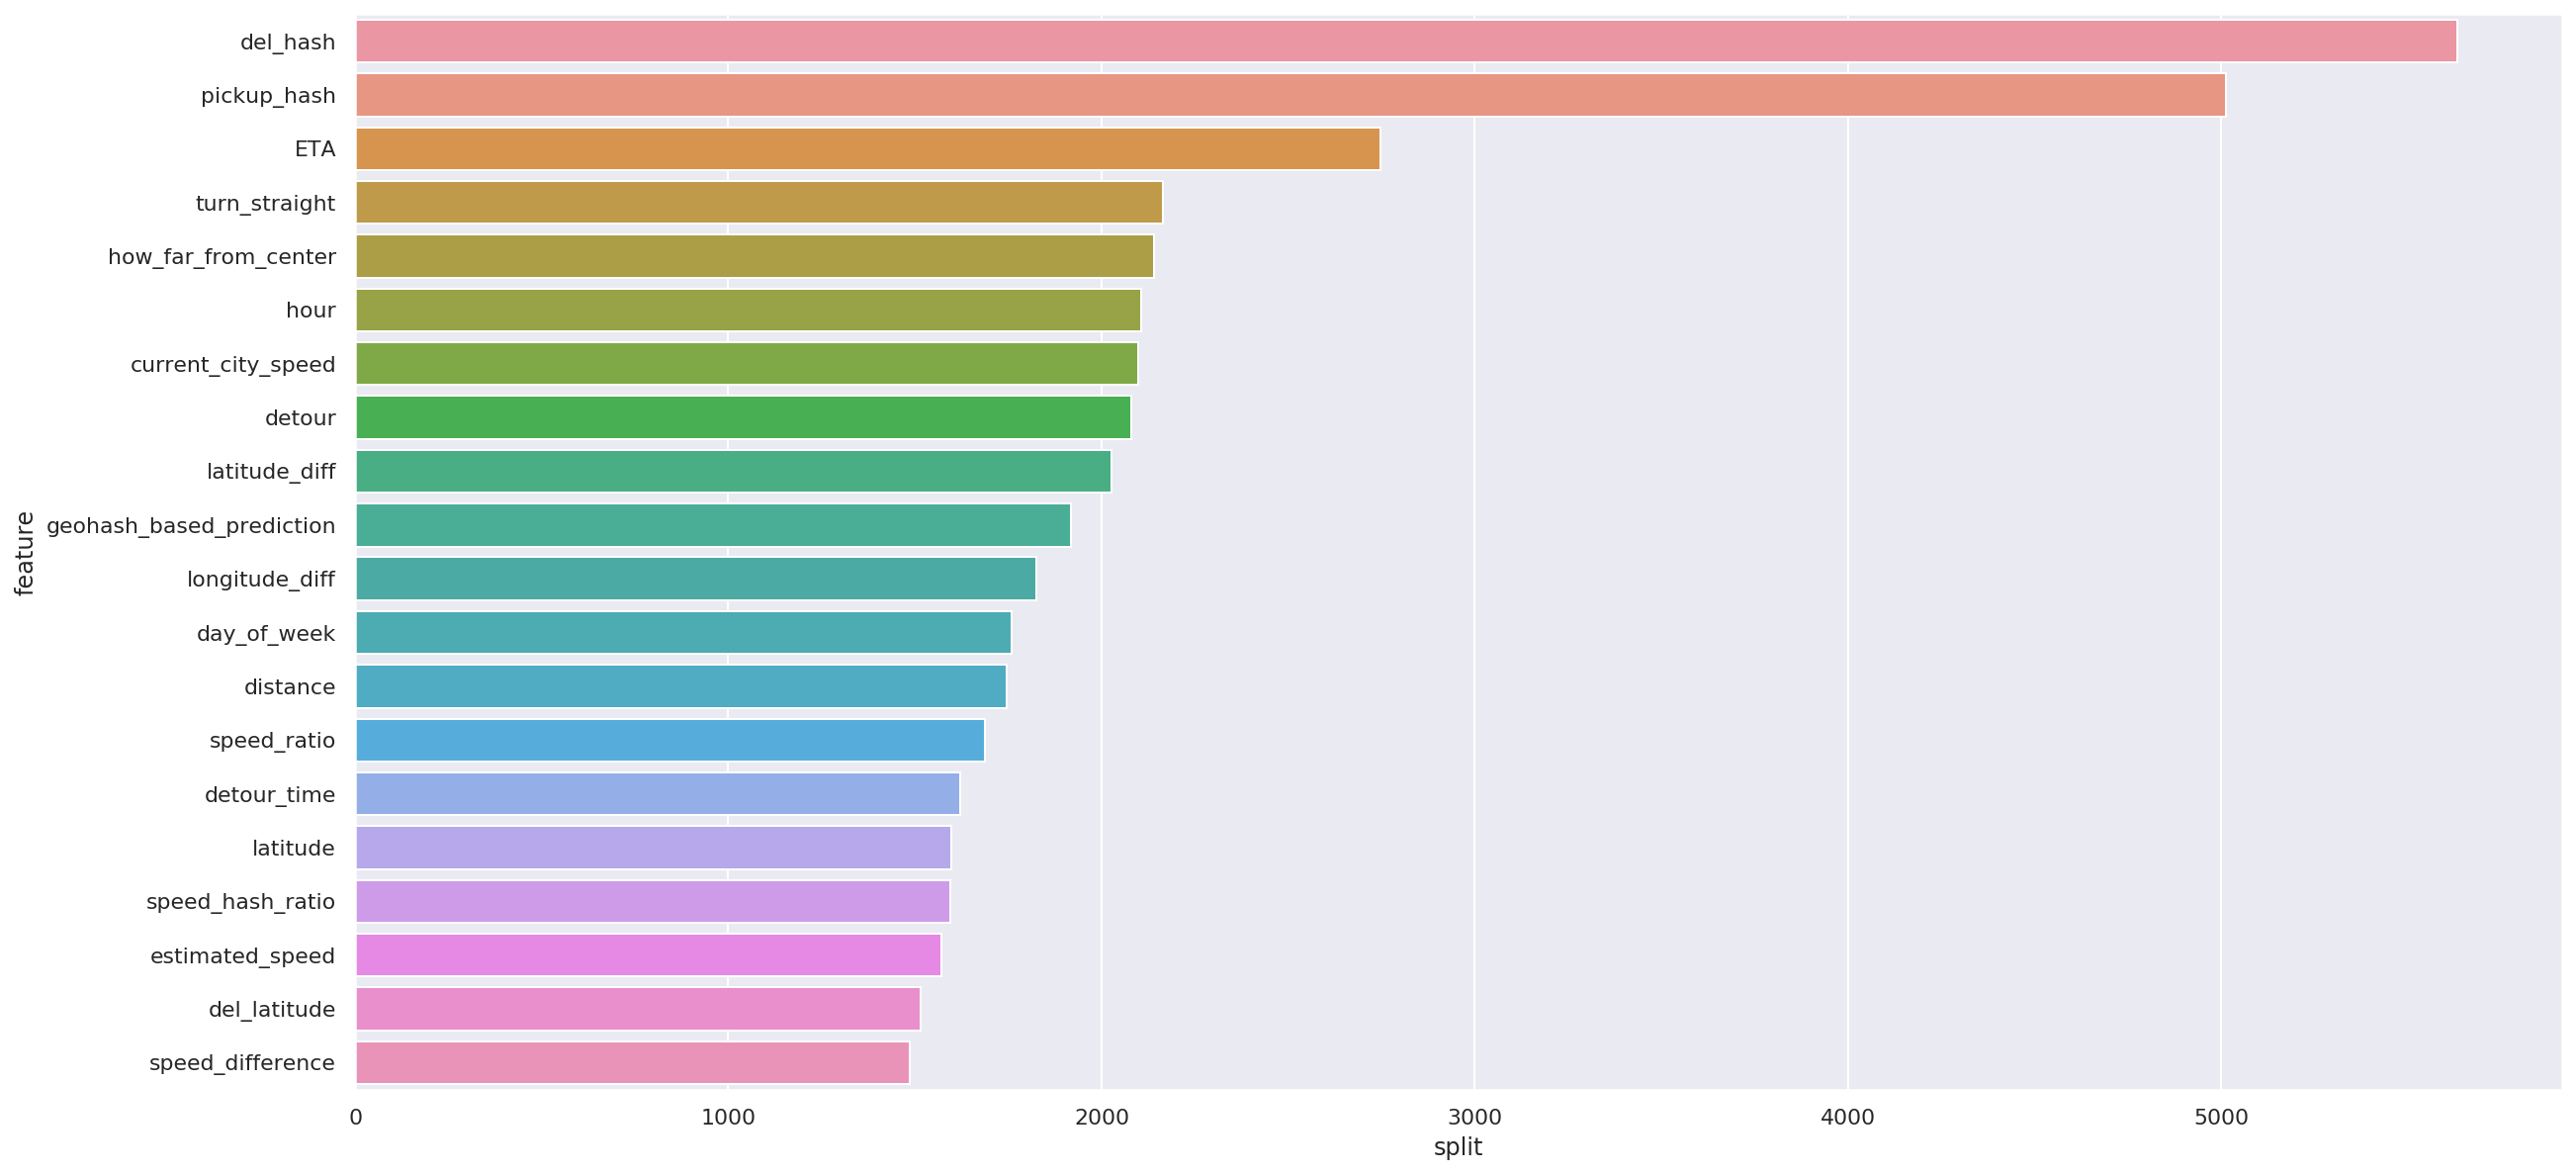

In [34]:
plot_importance(model_retrained, importance_type='split')

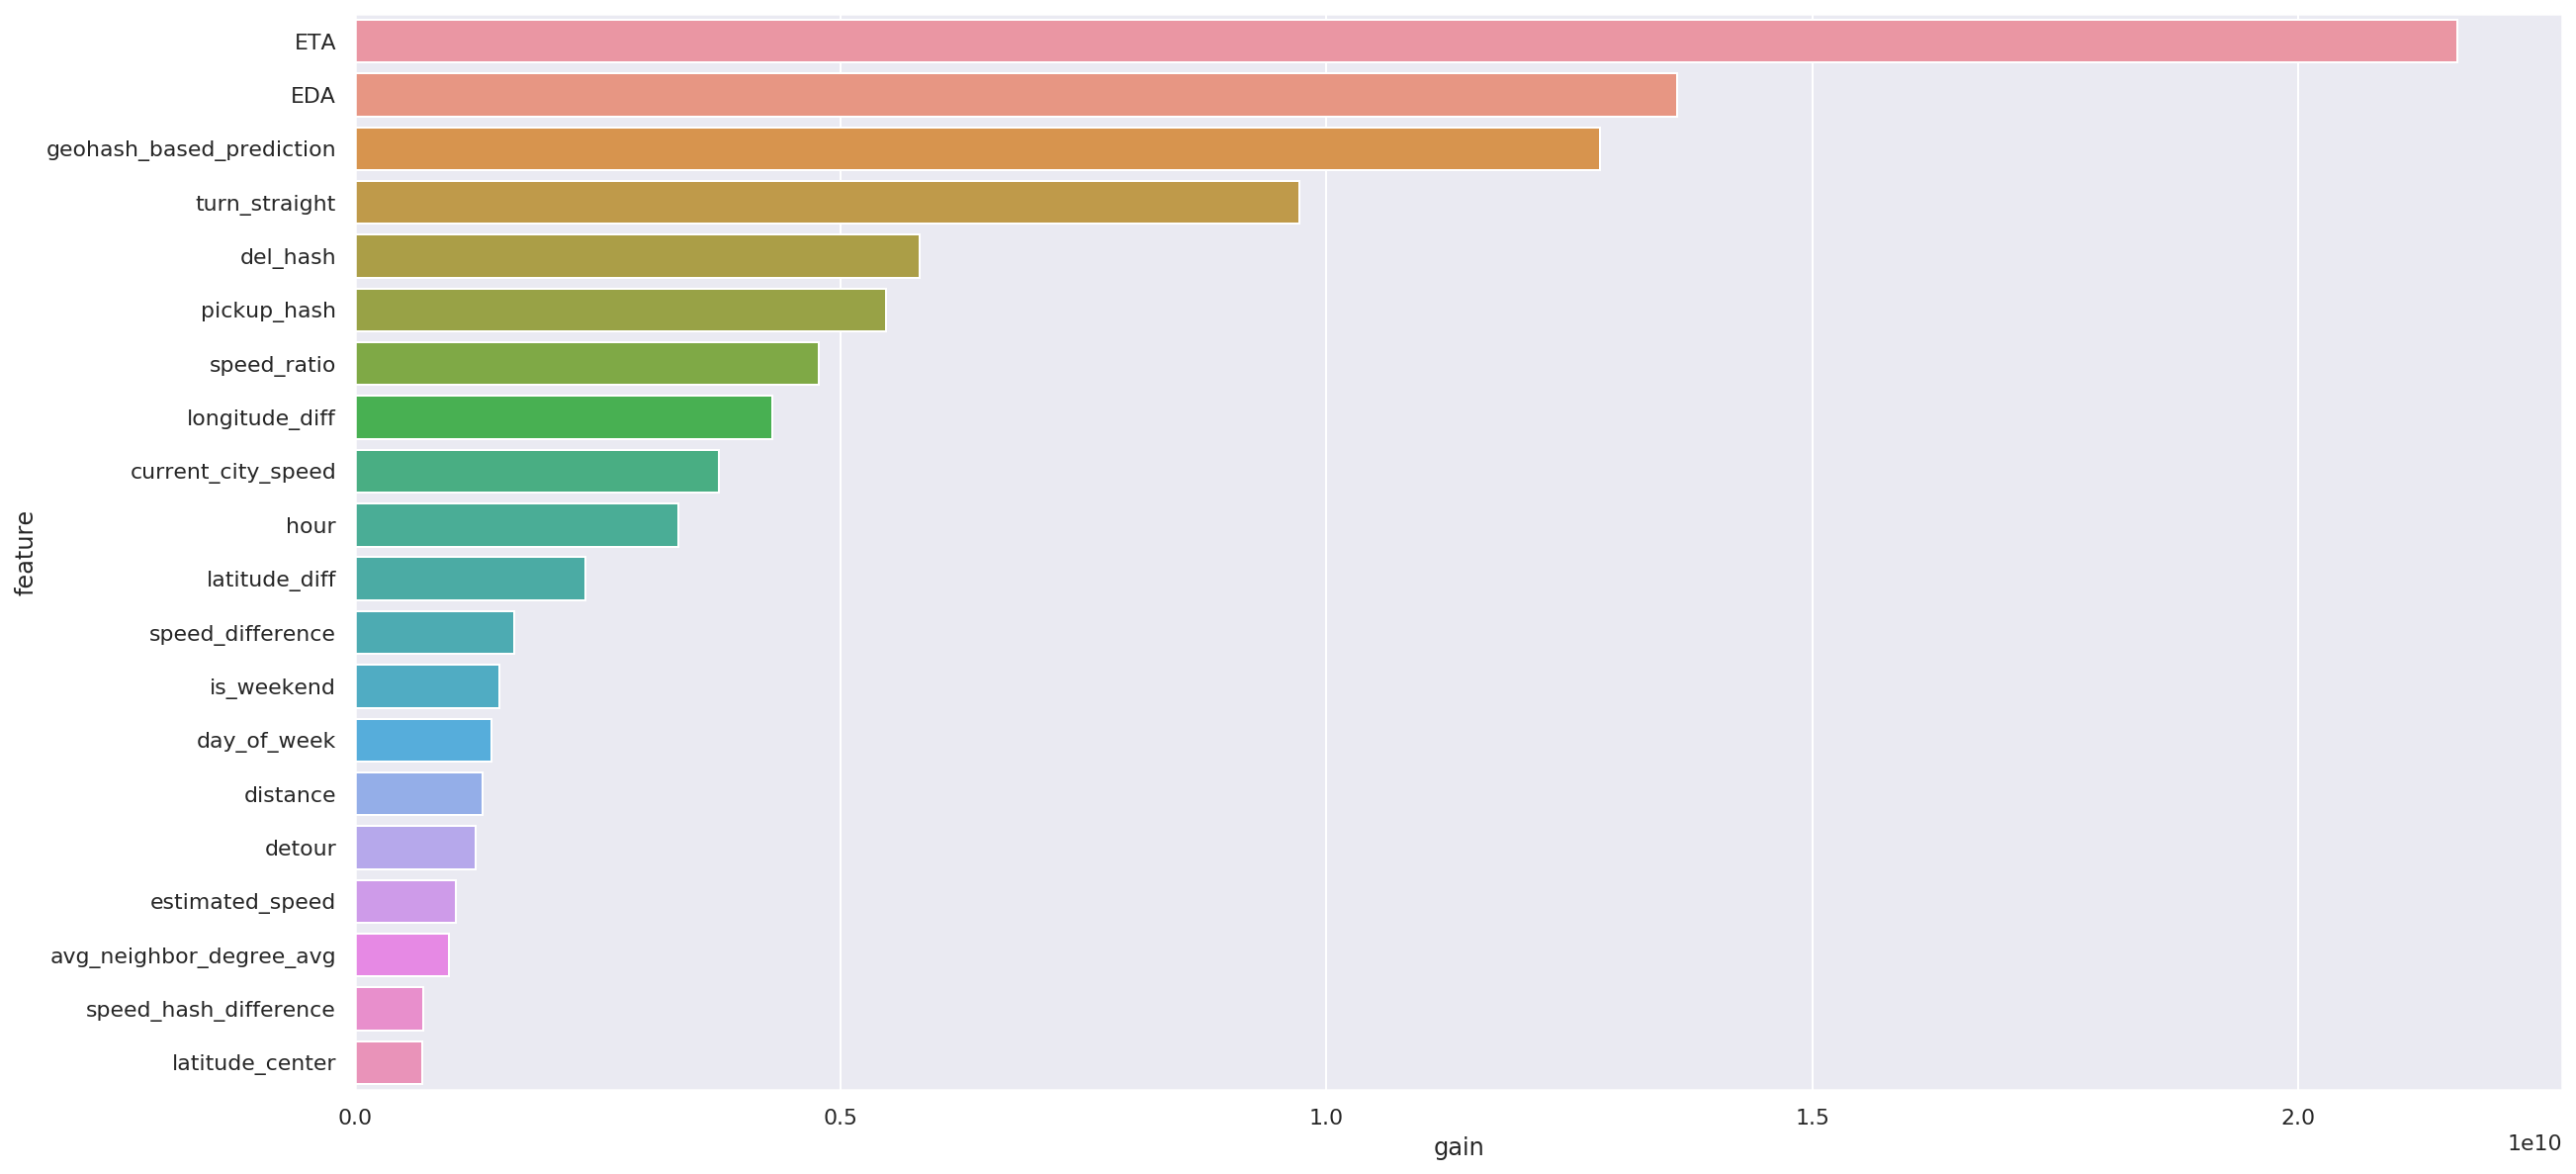

In [35]:
plot_importance(model_retrained, importance_type='gain')

Опционально можно построить важности признаков при помощи [shap](https://github.com/slundberg/shap)

In [36]:
use_shap = True

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


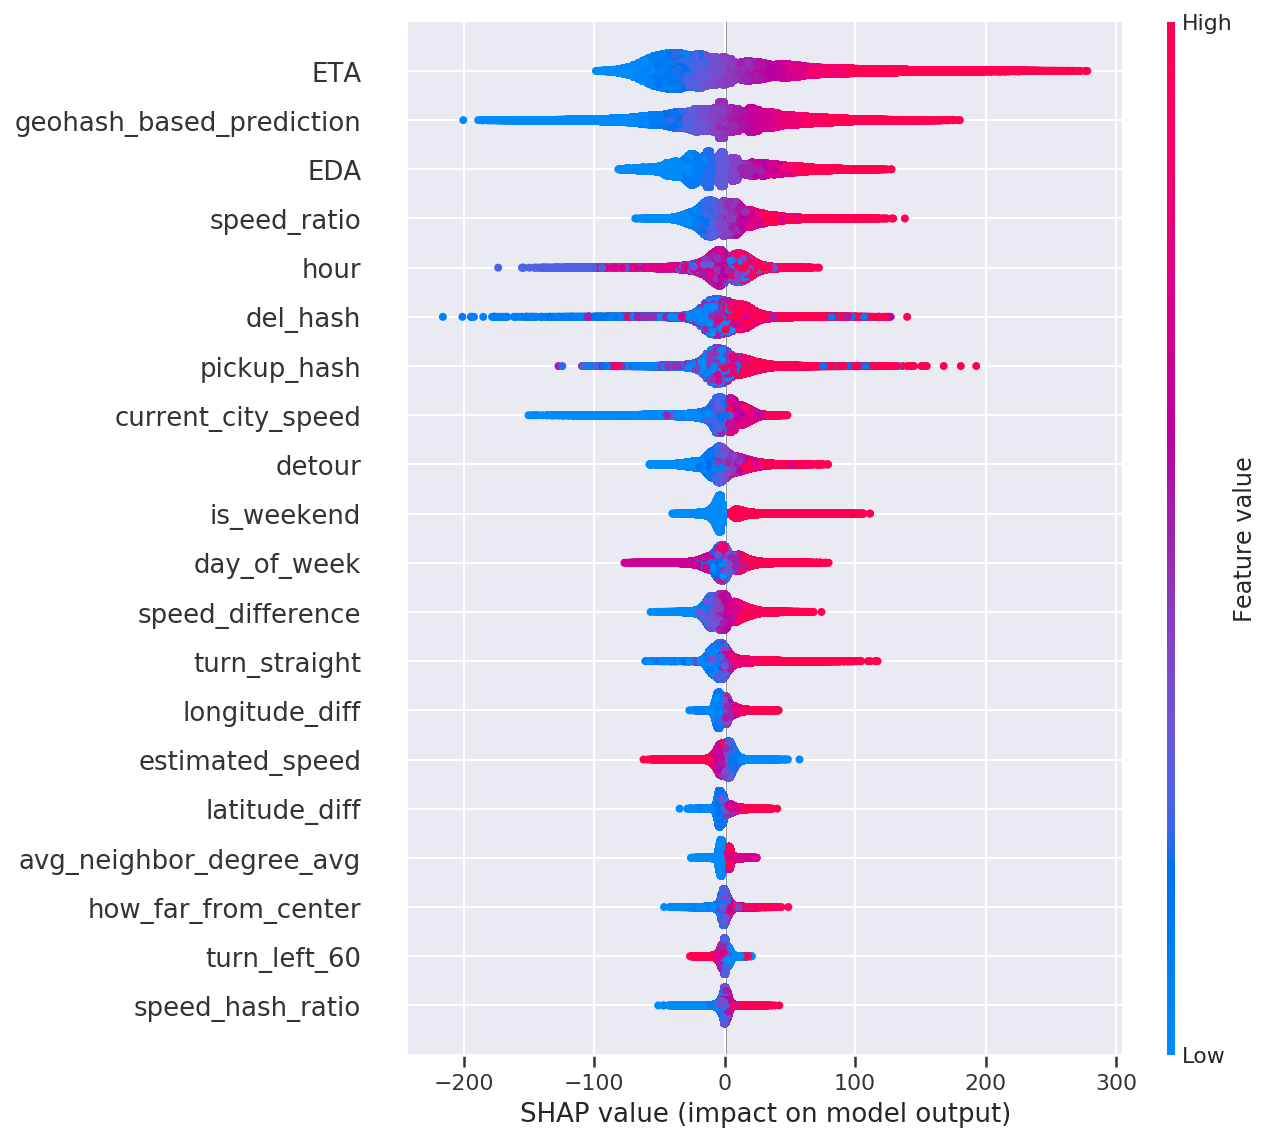

In [37]:
if use_shap:
    import shap 
    shap.initjs()
    shap_values = shap.TreeExplainer(model_retrained).shap_values(X_train)
    shap.summary_plot(shap_values, X_train)